['S_w', 'W_fw', 'A', 'Lambda', 'q', 'ell', 't_c', 'N_z', 'W_dg', 'W_p']


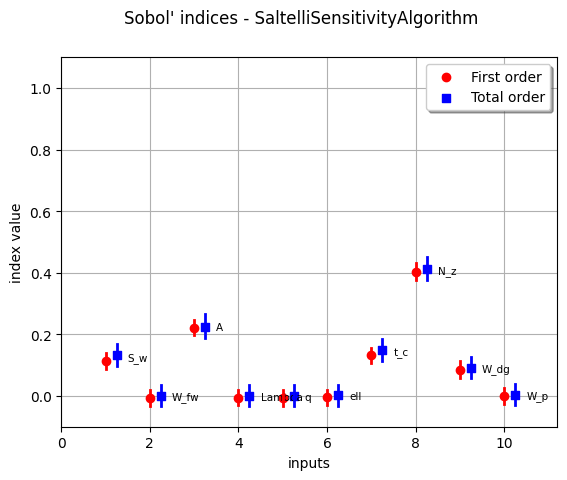

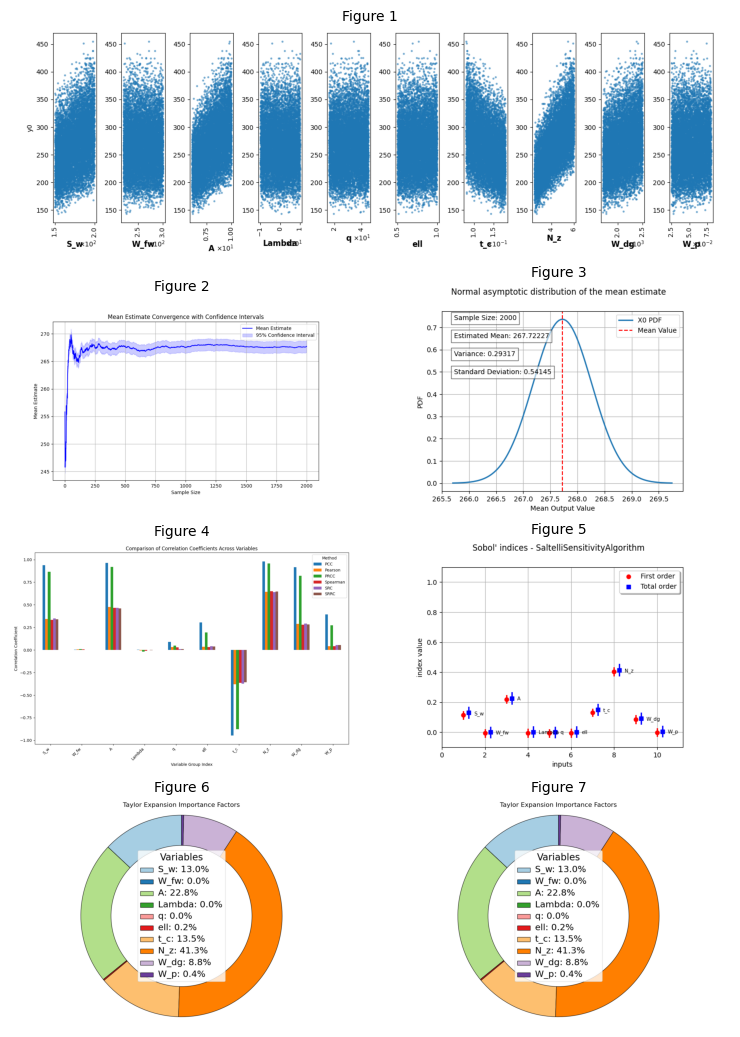

In [8]:
import importlib.util
import sys
import os
import pandas as pd
import openturns as ot
import openturns.viewer as otv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import shutil
import argparse
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
from PIL import Image
import numpy as np

# Constants for directories
OUTPUT_DIR = "results"
OUTPUT_VISUAL_DIR = "results_visual"
OUTPUT_API_DIR = "results_api"
FIGURES_DIR = "figures"

# Parse arguments
# parser = argparse.ArgumentParser(description="Run analysis script with the specified user model.")
# parser.add_argument("user_model_path", help="Path to the user model file")
# args = parser.parse_args()
# file_path = args.user_model_path

file_path = 'user_model.py'
# Load the user model
MODULE_NAME = "UserModel"


# Clean and create directories
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
shutil.rmtree(OUTPUT_VISUAL_DIR, ignore_errors=True)
shutil.rmtree(OUTPUT_API_DIR, ignore_errors=True)
shutil.rmtree(FIGURES_DIR, ignore_errors=True)

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_VISUAL_DIR, exist_ok=True)
os.makedirs(OUTPUT_API_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Load the user model
MODULE_NAME = "UserModel"
spec = importlib.util.spec_from_file_location(MODULE_NAME, file_path)
module = importlib.util.module_from_spec(spec)
sys.modules[MODULE_NAME] = module
spec.loader.exec_module(module)

# Dynamically set the model attribute
function_of_interest = module.function_of_interest
problem = module.problem
model = function_of_interest

# Create distributions
distributions = ot.DistributionCollection()
for dist_info in problem['distributions']:
    dist_type = dist_info['type']
    params = dist_info['params']
    if dist_type == 'Uniform':
        distributions.add(ot.Uniform(*params))
    elif dist_type == 'Normal':
        distributions.add(ot.Normal(*params))
    elif dist_type == 'LogNormalMuSigma':
        distributions.add(ot.ParametrizedDistribution(ot.LogNormalMuSigma(*params)))
    elif dist_type == 'LogNormal':
        distributions.add(ot.LogNormal(*params))
    elif dist_type == 'Beta':
        distributions.add(ot.Beta(*params))
    elif dist_type == 'Gumbel':
        distributions.add(ot.Gumbel(*params))
    elif dist_type == 'Triangular':
        distributions.add(ot.Triangular(*params))
    else:
        raise ValueError(f"Unsupported distribution type: {dist_type}")

distribution = ot.ComposedDistribution(distributions)
input_names = problem['names']

# Define the OpenTURNS model
ot_model = ot.PythonFunction(problem['num_vars'], 1, model)

# Draw the function
n = 10000
sampleX = distribution.getSample(n)
sampleY = ot_model(sampleX)

# Save data used in plotXvsY to CSV
sampleX.exportToCSVFile(os.path.join(OUTPUT_DIR, "X.csv"), ",")
sampleY.exportToCSVFile(os.path.join(OUTPUT_DIR, "Y.csv"), ",")

X = pd.read_csv(os.path.join(OUTPUT_DIR, 'X.csv'))
Y = pd.read_csv(os.path.join(OUTPUT_DIR, 'Y.csv'))
X.columns = problem['names']
print(problem['names'])

grid_df = pd.concat([Y, X], axis=1)
grid_df.to_csv(os.path.join(OUTPUT_DIR, "grid.csv"), index=False)

# Estimate the Sobol' indices
size = 10000
sie = ot.SobolIndicesExperiment(distribution, size)
inputDesign = sie.generate()
inputDesign.setDescription(input_names)
outputDesign = ot_model(inputDesign)

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

graph = sensitivityAnalysis.draw()
view = otv.View(graph)
plt.savefig(os.path.join(OUTPUT_VISUAL_DIR, "sobol_indices.png"))

# Create DataFrames for Sobol indices
rows = str(sensitivityAnalysis.getFirstOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getFirstOrderIndices()).split('#')[0].strip('[]').split(',')))})
first_order_df = pd.concat([pd.DataFrame({'Inputs': input_names}), new_df, df], axis=1)

rows = str(sensitivityAnalysis.getTotalOrderIndicesInterval()).split('\n')
data = [tuple(map(float, row.strip('[]').split(','))) for row in rows]
df = pd.DataFrame(data, columns=['Upper Bound', 'Lower Bound'])
new_df = pd.DataFrame({'Sobol Index': list(map(float, str(sensitivityAnalysis.getTotalOrderIndices()).split('#')[0].strip('[]').split(',')))})
total_order_df = pd.concat([pd.DataFrame({'Inputs': input_names}), new_df, df], axis=1)

# Save Sobol indices to CSV
first_order_df.to_csv(os.path.join(OUTPUT_DIR, "first_order_sobol_indices.csv"), index=False)
total_order_df.to_csv(os.path.join(OUTPUT_DIR, "total_order_sobol_indices.csv"), index=False)

# Define the input distribution
input_vector = ot.RandomVector(distribution)
output_vector = ot.CompositeRandomVector(ot_model, input_vector)

# Taylor expansion moments and importance factors
taylor = ot.TaylorExpansionMoments(output_vector)
importance_factors = taylor.getImportanceFactors()

# Extract the importance factors and replace labels with problem names
importance_values = [importance_factors[i] * 100 for i in range(len(problem['names']))]
variable_names = problem['names']

# Save the Taylor importance factors as a pie chart
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Paired(np.arange(len(variable_names)))

# Create the pie chart with black borders
wedges, texts = ax.pie(
    importance_values, 
    startangle=90, 
    colors=colors, 
    wedgeprops=dict(width=0.3, edgecolor='black')
)

# Remove the percentage labels from the pie chart
# Add the percentages to the legend labels
legend_labels = [f'{var}: {val:.1f}%' for var, val in zip(variable_names, importance_values)]

# Add a legend in the center of the doughnut chart
from matplotlib.patches import Rectangle

# Center the legend
center_legend = ax.legend(
    wedges, 
    legend_labels, 
    title="Variables", 
    loc="center", 
    fontsize=16, 
    title_fontsize='17'
)

# Increase the size of the legend by 40%
for text in center_legend.get_texts():
    text.set_fontsize(text.get_fontsize() * 1.4)
center_legend.get_title().set_fontsize(center_legend.get_title().get_fontsize() * 1.4)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Set title with increased font size
plt.title('Taylor Expansion Importance Factors', fontsize=16)

# Save the pie chart
taylor_output_path = os.path.join(OUTPUT_VISUAL_DIR, "taylor_importance_factors.png")
plt.tight_layout()
plt.savefig(taylor_output_path)
plt.close()

# Define the algorithm for expectation convergence
algo = ot.ExpectationSimulationAlgorithm(output_vector)
algo.setMaximumOuterSampling(8000)
algo.setBlockSize(1)
algo.setCoefficientOfVariationCriterionType("NONE")

# Run the algorithm and store the result
algo.run()
result = algo.getResult()

# Draw the convergence history and save the convergence data to a CSV file
graphConvergence = algo.drawExpectationConvergence()
data = graphConvergence.getDrawable(0).getData()
sample_sizes = data[:, 0]
mean_estimates = data[:, 1]

# Compute standard deviations for the mean estimates
standard_deviations = result.getStandardDeviation()

# Calculate confidence intervals
z_value = 1.96  # For a 95% confidence interval
lower_bounds = mean_estimates - z_value * standard_deviations
upper_bounds = mean_estimates + z_value * standard_deviations

df = pd.DataFrame({
    "Sample Size": [point[0] for point in sample_sizes],
    "Mean Estimate": [point[0] for point in mean_estimates],
    "Lower Bound": [point[0] for point in lower_bounds],
    "Upper Bound": [point[0] for point in upper_bounds]
})
df.to_csv(os.path.join(OUTPUT_DIR, "expectation_convergence.csv"), index=False)

# Get the last sample size
last_sample_size = int(df["Sample Size"].tolist()[-1])

# Get the key statistics from the result
expectation = result.getExpectationEstimate()[0]
expectation_variance = result.getVarianceEstimate()[0]
standard_deviation = result.getStandardDeviation()[0]
expectation_distribution = result.getExpectationDistribution()

# Save statistics to CSV
stats_df = pd.DataFrame({
    "Sample Size": [df["Sample Size"].tolist()[-1]],  # Assuming df is still in scope from previous code
    "Expectation": [expectation],
    "Variance": [expectation_variance],
    "Standard Deviation": [standard_deviation]
})

stats_output_path = os.path.join(OUTPUT_API_DIR, "statistics.csv")
stats_df.to_csv(stats_output_path, index=False)

# Save the normal asymptotic distribution of the mean estimate plot
graph_expectation_distribution = expectation_distribution.drawPDF()
graph_expectation_distribution.setTitle("Normal asymptotic distribution of the mean estimate")

# Annotate the plot with key statistics and sample size
fig, ax = plt.subplots()
otv.View(graph_expectation_distribution, figure=fig, axes=[ax])

# Highlight mean value with a vertical dotted line
ax.axvline(expectation, color='r', linestyle='--', label='Mean Value')

# Annotate with key statistics
ax.annotate(f"Sample Size: {last_sample_size}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6))
ax.annotate(f"Estimated Mean: {expectation:.5f}", xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6))
ax.annotate(f"Variance: {expectation_variance:.5f}", xy=(0.05, 0.75), xycoords='axes fraction', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6))
ax.annotate(f"Standard Deviation: {standard_deviation:.5f}", xy=(0.05, 0.65), xycoords='axes fraction', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.6))

# Set x-axis label
ax.set_xlabel("Mean Output Value")

# Add legend
ax.legend()

# Save the annotated plot
output_plot_path = os.path.join(OUTPUT_VISUAL_DIR, "normal_asymptotic_distribution_of_mean_estimate.png")
fig.savefig(output_plot_path)
plt.close(fig)

# Perform correlation analysis and save results to CSV
corr_analysis = ot.CorrelationAnalysis(sampleX, sampleY)

methods = {
    "PCC": corr_analysis.computePCC,
    "PRCC": corr_analysis.computePRCC,
    "SRC": corr_analysis.computeSRC,
    "SRRC": corr_analysis.computeSRRC,
    "Pearson": corr_analysis.computePearsonCorrelation,
    "Spearman": corr_analysis.computeSpearmanCorrelation,
}

for method, func in methods.items():
    indices = func()
    data = {
        'Variable': f"[{','.join(input_names)}]",
        'Correlation_Coefficient': list(indices)
    }
    df = pd.DataFrame(data)
    df.to_csv(os.path.join(OUTPUT_DIR, f"{method}_coefficients.csv"), index=False)

# Combine CSV files for correlation coefficients
combined_df = None
for file in os.listdir(OUTPUT_DIR):
    if file.endswith('_coefficients.csv'):
        method = file.replace('_coefficients.csv', '')
        df = pd.read_csv(os.path.join(OUTPUT_DIR, file))
        df = df.rename(columns={'Correlation_Coefficient': method})
        if combined_df is None:
            combined_df = df
        else:
            combined_df[method] = df[method]
combined_df.to_csv(os.path.join(OUTPUT_DIR, 'combined_coefficients.csv'), index=False)

# Transform combined coefficients CSV for API consumption
combined_df = pd.read_csv(os.path.join(OUTPUT_DIR, 'combined_coefficients.csv'))
variables = combined_df['Variable'][0].strip('[]').split(',')
combined_df['Variable'] = variables
combined_df.to_csv(os.path.join(OUTPUT_API_DIR, 'combined_coefficients_transformed.csv'), index=False)

# Copy necessary files to the API results directory
files_to_copy = [
    os.path.join(OUTPUT_DIR, "expectation_convergence.csv"),
    os.path.join(OUTPUT_DIR, "first_order_sobol_indices.csv"),
    os.path.join(OUTPUT_DIR, "total_order_sobol_indices.csv")
]
for file in files_to_copy:
    destination_file = os.path.join(OUTPUT_API_DIR, os.path.basename(file))
    shutil.copyfile(file, destination_file)

# Generate plots
df = pd.read_csv(os.path.join(OUTPUT_DIR, 'combined_coefficients.csv'))
xticks = df['Variable'][0].strip('[]').replace("'", "").split(',')
df['Variable'] = df.index
df.set_index('Variable', inplace=True)
ax = df.plot(kind='bar', figsize=(12, 8))
plt.xlabel('Variable Group Index')
plt.ylabel('Correlation Coefficient')
plt.title('Comparison of Correlation Coefficients Across Variables')
plt.legend(title='Method')
ax.set_xticklabels(xticks, rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_VISUAL_DIR, "correlation_coefficients.png"))
plt.close()

data = pd.read_csv(os.path.join(OUTPUT_DIR, "expectation_convergence.csv"))
plt.figure(figsize=(10, 6))
plt.plot(data['Sample Size'], data['Mean Estimate'], label='Mean Estimate', color='blue')
plt.fill_between(data['Sample Size'], data['Lower Bound'], data['Upper Bound'], color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title('Mean Estimate Convergence with Confidence Intervals')
plt.xlabel('Sample Size')
plt.ylabel('Mean Estimate')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_VISUAL_DIR, "mean_estimate_convergence_plot.png"))
plt.close()

df = pd.read_csv(os.path.join(OUTPUT_DIR, 'grid.csv'))
y = df['y0']
X = df.drop(columns=['y0'])
X_names = X.columns
dimX = X.shape[1]
fig, axes = plt.subplots(1, dimX, figsize=(15, 5))
for j in range(dimX):
    ax = axes[j] if dimX > 1 else axes
    ax.scatter(X.iloc[:, j], y, alpha=0.5, s=5)
    ax.set_xlabel(X_names[j], fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=90)
    if j == 0:
        ax.set_ylabel('y0')
    else:
        ax.set_ylabel("")
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_VISUAL_DIR, "grid_plot.png"))
plt.close()

results_folder = 'results_visual'
fig = plt.figure(figsize=(7.5, 10.5))
gs = GridSpec(4, 2, figure=fig, height_ratios=[1, 1, 1, 1])

axes = [
    fig.add_subplot(gs[0, :]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1]),
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[3, 0]),
    fig.add_subplot(gs[3, 1])
]

images = [
    ('grid_plot.png', axes[0], "Figure 1"),
    ('mean_estimate_convergence_plot.png', axes[1], "Figure 2"),
    ('normal_asymptotic_distribution_of_mean_estimate.png', axes[2], "Figure 3"),
    ('correlation_coefficients.png', axes[3], "Figure 4"),
    ('sobol_indices.png', axes[4], "Figure 5"),
    ('taylor_importance_factors.png', axes[5], "Figure 6"),
    ('taylor_importance_factors.png', axes[6], "Figure 7")
]

for img_name, ax, title in images:
    img_path = os.path.join(results_folder, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(title, fontsize=10, pad=5)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1, wspace=0.1)

output_path = os.path.join(results_folder, 'combined.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

figures_to_copy = [
    "correlation_coefficients.png",
    "grid_plot.png",
    "mean_estimate_convergence_plot.png",
    "sobol_indices.png",
    "combined.png"
]
for figure in figures_to_copy:
    shutil.copyfile(os.path.join(OUTPUT_VISUAL_DIR, figure), os.path.join(FIGURES_DIR, figure))


In [7]:
str(sensitivityAnalysis.getFirstOrderIndices()).split('#')[0]

'[0.140883,0.0159168,0.233458,0.0162815,0.0157623,0.0171699,0.157311,0.412463,0.102114,0.0187845]'

In [15]:
import openturns.viewer as viewer

minValue = 0.9
maxValue = 1.0
quantileScale = True
graphCobweb = ot.VisualTest.DrawParallelCoordinates(
    X, Y, minValue, maxValue, "red", quantileScale
)
graphCobweb.setLegendPosition("lower right")
view = viewer.View(graphCobweb)
plt.show()

TypeError: Wrong number or type of arguments for overloaded function 'DrawParallelCoordinates'.
  Possible C/C++ prototypes are:
    OT::VisualTest::DrawParallelCoordinates(OT::Sample const &,OT::Sample const &,OT::Scalar const,OT::Scalar const,OT::String const &,OT::Bool const)
    OT::VisualTest::DrawParallelCoordinates(OT::Sample const &,OT::Sample const &,OT::Scalar const,OT::Scalar const,OT::String const &)
